In [91]:
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
from pandas import Series

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, CuDNNLSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf

In [92]:
csv_path = 'inp/IBIRITE (ROLA MOCA)_MG.csv'

In [93]:
data = pd.read_csv(csv_path, sep=';')
data_copy = data.copy()
data


,DATE,Chuva,$Pressão_{Inst}$,$Pressão_{Max}$,$Pressão_{Min}$,$Temperatura_{Inst}$,$Orvalho_{Inst}$,$Temperatura_{Max}$,$Temperatura_{Min}$,$Orvalho_{Max}$,...,$Umidade_{Min}$,$Umidade_{Inst}$,$Vento_{Dir}$,$Vento_{Raj}$,$Vento_{Vel}$,GLOBAL,Latitude,Longitude,Altitude,Qo
0,2008-06-06,0.000000,886.500000,886.533333,886.300000,21.100000,10.500000,22.333333,20.900000,10.766667,...,48.333333,51.666667,56.333333,6.233333,3.133333,1.9223,-20.031457,-44.011249,1198.82,2.195897
1,2008-06-07,0.000000,887.037500,887.250000,886.854167,19.458333,10.083333,20.016667,18.770833,10.637500,...,54.000000,56.458333,76.458333,6.604167,3.537500,19.2513,-20.031457,-44.011249,1198.82,24.544495
2,2008-06-08,0.000000,886.783333,886.983333,886.583333,19.095833,10.504167,19.704167,18.458333,11.054167,...,55.458333,58.750000,79.791667,8.570833,4.383333,17.9175,-20.031457,-44.011249,1198.82,24.486118
3,2008-06-09,0.000000,886.341667,886.516667,886.204167,18.700000,12.312500,19.304167,18.079167,12.662500,...,64.541667,67.583333,125.875000,7.779167,4.033333,16.2483,-20.031457,-44.011249,1198.82,24.430901
4,2008-06-10,0.000000,885.012500,885.220833,884.820833,18.529167,11.920833,19.291667,17.795833,12.566667,...,64.916667,67.833333,139.625000,4.750000,2.329167,13.3562,-20.031457,-44.011249,1198.82,24.378872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4792,2021-12-27,0.000000,880.675000,880.900000,880.425000,22.075000,14.425000,22.783333,21.395833,15.054167,...,60.291667,63.416667,174.083333,6.562500,1.462500,26.3813,-20.031457,-44.011249,1198.82,42.703244
4793,2021-12-28,0.983333,881.758333,882.012500,881.445833,21.458333,15.970833,22.525000,20.708333,16.695833,...,68.333333,72.875000,176.750000,7.200000,1.875000,23.1625,-20.031457,-44.011249,1198.82,42.712820
4794,2021-12-29,0.150000,883.337500,883.616667,883.075000,19.704167,16.345833,20.341667,19.187500,16.850000,...,78.791667,82.000000,131.375000,5.400000,0.254167,18.4593,-20.031457,-44.011249,1198.82,42.718808
4795,2021-12-30,1.008333,881.166667,881.458333,880.958333,18.454167,16.762500,18.820833,18.204167,17.050000,...,88.375000,89.875000,98.000000,5.812500,1.733333,5.3534,-20.031457,-44.011249,1198.82,42.721202


In [94]:
data.rename(columns={"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)": "Chuva",
                     "PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)": "$Pressão_{Inst}$",
                     "PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)": "$Pressão_{Max}$",
                     "PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)": "$Pressão_{Min}$",
                     "RADIACAO GLOBAL (KJ/m²)": "H",
                     "TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)": "$Temperatura_{Inst}$",
                     "TEMPERATURA DO PONTO DE ORVALHO (°C)": "$Orvalho_{Inst}$",
                     "TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)": "$Temperatura_{Max}$",
                     "TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)": "$Temperatura_{Min}$",
                     "TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)": "$Orvalho_{Max}$",
                     "TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)": "$Orvalho_{Min}$",
                     "UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)": "$Umidade_{Max}$",
                     "UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)": "$Umidade_{Min}$",
                     "UMIDADE RELATIVA DO AR, HORARIA (%)": "$Umidade_{Inst}$",
                     "VENTO, DIREÇÃO HORARIA (gr) (° (gr))": "$Vento_{Dir}$",
                     "VENTO, RAJADA MAXIMA (m/s)": "$Vento_{Raj}$",
                     "VENTO, VELOCIDADE HORARIA (m/s)": "$Vento_{Vel}$",
                     "RADIACAO GLOBAL (Kj/m²)": "GLOBAL"}, inplace=True)
data

,DATE,Chuva,$Pressão_{Inst}$,$Pressão_{Max}$,$Pressão_{Min}$,$Temperatura_{Inst}$,$Orvalho_{Inst}$,$Temperatura_{Max}$,$Temperatura_{Min}$,$Orvalho_{Max}$,...,$Umidade_{Min}$,$Umidade_{Inst}$,$Vento_{Dir}$,$Vento_{Raj}$,$Vento_{Vel}$,GLOBAL,Latitude,Longitude,Altitude,Qo
0,2008-06-06,0.000000,886.500000,886.533333,886.300000,21.100000,10.500000,22.333333,20.900000,10.766667,...,48.333333,51.666667,56.333333,6.233333,3.133333,1.9223,-20.031457,-44.011249,1198.82,2.195897
1,2008-06-07,0.000000,887.037500,887.250000,886.854167,19.458333,10.083333,20.016667,18.770833,10.637500,...,54.000000,56.458333,76.458333,6.604167,3.537500,19.2513,-20.031457,-44.011249,1198.82,24.544495
2,2008-06-08,0.000000,886.783333,886.983333,886.583333,19.095833,10.504167,19.704167,18.458333,11.054167,...,55.458333,58.750000,79.791667,8.570833,4.383333,17.9175,-20.031457,-44.011249,1198.82,24.486118
3,2008-06-09,0.000000,886.341667,886.516667,886.204167,18.700000,12.312500,19.304167,18.079167,12.662500,...,64.541667,67.583333,125.875000,7.779167,4.033333,16.2483,-20.031457,-44.011249,1198.82,24.430901
4,2008-06-10,0.000000,885.012500,885.220833,884.820833,18.529167,11.920833,19.291667,17.795833,12.566667,...,64.916667,67.833333,139.625000,4.750000,2.329167,13.3562,-20.031457,-44.011249,1198.82,24.378872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4792,2021-12-27,0.000000,880.675000,880.900000,880.425000,22.075000,14.425000,22.783333,21.395833,15.054167,...,60.291667,63.416667,174.083333,6.562500,1.462500,26.3813,-20.031457,-44.011249,1198.82,42.703244
4793,2021-12-28,0.983333,881.758333,882.012500,881.445833,21.458333,15.970833,22.525000,20.708333,16.695833,...,68.333333,72.875000,176.750000,7.200000,1.875000,23.1625,-20.031457,-44.011249,1198.82,42.712820
4794,2021-12-29,0.150000,883.337500,883.616667,883.075000,19.704167,16.345833,20.341667,19.187500,16.850000,...,78.791667,82.000000,131.375000,5.400000,0.254167,18.4593,-20.031457,-44.011249,1198.82,42.718808
4795,2021-12-30,1.008333,881.166667,881.458333,880.958333,18.454167,16.762500,18.820833,18.204167,17.050000,...,88.375000,89.875000,98.000000,5.812500,1.733333,5.3534,-20.031457,-44.011249,1198.82,42.721202


In [95]:
data.set_index('DATE', inplace=True)
data.dropna(axis=0, how='all', subset=None, inplace=True)
data.dropna(axis=1, how='all', subset=None, inplace=True)

In [96]:
#DEPENDENDO DO ANO E DA ESTAÇÃO OS VALORES DE RADIAÇÃO ESTÃO EM COLUNAS DIFERENTES
if 'GLOBAL' not in data.columns:
    data.rename(columns={"H": "GLOBAL"}, inplace=True)
if 'H' in data.columns:
    data['GLOBAL'].fillna(data['H'], inplace=True)
    data.drop(['H'], axis=1, inplace=True)

In [97]:
train_dates = pd.to_datetime(data.index)
data = data[
    ['$Temperatura_{Inst}$', '$Temperatura_{Max}$', '$Temperatura_{Min}$', '$Umidade_{Max}$', '$Umidade_{Min}$',
     '$Umidade_{Inst}$', 'GLOBAL']]

cols = list(data)[0:7]
data = data[cols].astype(float)
data

,$Temperatura_{Inst}$,$Temperatura_{Max}$,$Temperatura_{Min}$,$Umidade_{Max}$,$Umidade_{Min}$,$Umidade_{Inst}$,GLOBAL
DATE,,,,,,,
2008-06-06,21.100000,22.333333,20.900000,52.333333,48.333333,51.666667,1.9223
2008-06-07,19.458333,20.016667,18.770833,59.333333,54.000000,56.458333,19.2513
2008-06-08,19.095833,19.704167,18.458333,61.333333,55.458333,58.750000,17.9175
2008-06-09,18.700000,19.304167,18.079167,69.916667,64.541667,67.583333,16.2483
2008-06-10,18.529167,19.291667,17.795833,71.625000,64.916667,67.833333,13.3562
...,...,...,...,...,...,...,...
2021-12-27,22.075000,22.783333,21.395833,66.375000,60.291667,63.416667,26.3813
2021-12-28,21.458333,22.525000,20.708333,76.458333,68.333333,72.875000,23.1625
2021-12-29,19.704167,20.341667,19.187500,84.708333,78.791667,82.000000,18.4593


In [98]:
# GARANTINDO QUE TODOS OS DADOS ESTÃO SENDO TRATADOS COMO FLOAT
data = data.replace(',', '.', regex=True)
data['$Temperatura_{Inst}$'] = data['$Temperatura_{Inst}$'].astype(float)
data['$Temperatura_{Max}$'] = data['$Temperatura_{Max}$'].astype(float)
data['$Temperatura_{Min}$'] = data['$Temperatura_{Min}$'].astype(float)
data['GLOBAL'] = data['GLOBAL'].astype(float)

In [99]:
#DELETANDO ALGUMA LEITURA ONDE O MÁXIMO É MENOR QUE O MÍNIMO
delIndex = data.loc[(data['$Temperatura_{Max}$'] < data['$Temperatura_{Min}$']) | (
        data['$Umidade_{Max}$'] < data['$Umidade_{Min}$'])].index
if len(delIndex) > 0:
    data.drop(delIndex, axis=0, inplace=True)

In [100]:
#DELETANDO ALGUMA LEITURA ONDE O MÁXIMO É MENOR QUE O INSTANTÂNEO
delIndex = data.loc[(data['$Temperatura_{Max}$'] < data['$Temperatura_{Inst}$']) | (
        data['$Umidade_{Max}$'] < data['$Umidade_{Inst}$'])].index
if len(delIndex) > 0:
    data.drop(delIndex, axis=0, inplace=True)

In [101]:
#DELETANDO ALGUMA LEITURA ONDE O INSTANTÂNEO É MENOR QUE O MÍNIMO
delIndex = data.loc[(data['$Temperatura_{Inst}$'] < data['$Temperatura_{Min}$']) | (
        data['$Umidade_{Inst}$'] < data['$Umidade_{Min}$'])].index
if len(delIndex) > 0:
    data.drop(delIndex, axis=0, inplace=True)

In [102]:
# #MODIFICANDO A UNIDADE DA RADIAÇÃO DE (Kj/m²) PARA (Mj/m²)
data['GLOBAL'] = data['GLOBAL'].mul(0.001)

In [103]:
#DELETANDO ALGUMA LINHA QUE AINDA TENHA NAN
data.dropna(inplace=True)

In [104]:
# EXTRAINDO OS NOMES DAS COLUNAS
target_names = ['GLOBAL']
variable_names = data.columns.values
variable_names = np.delete(variable_names, np.where(variable_names == target_names))

In [105]:
date_range = data.index

var_to_plot = data.columns
df = data[var_to_plot]

n = int(df.shape[0] * 0.7)
df.index = range(df.shape[0])
id0 = df.index <= n
id1 = df.index > n
print(data.index)

Index(['2008-06-06', '2008-06-07', '2008-06-08', '2008-06-09', '2008-06-10',
       '2008-06-11', '2008-06-12', '2008-06-13', '2008-06-14', '2008-06-15',
       ...
       '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25', '2021-12-26',
       '2021-12-27', '2021-12-28', '2021-12-29', '2021-12-30', '2021-12-31'],
      dtype='object', name='DATE', length=4797)


In [106]:
X = data[variable_names]
y = data[target_names]

In [107]:
# normalizing the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(data)


In [108]:
print(X)

            $Temperatura_{Inst}$  $Temperatura_{Max}$  $Temperatura_{Min}$  \
DATE                                                                         
2008-06-06             21.100000            22.333333            20.900000   
2008-06-07             19.458333            20.016667            18.770833   
2008-06-08             19.095833            19.704167            18.458333   
2008-06-09             18.700000            19.304167            18.079167   
2008-06-10             18.529167            19.291667            17.795833   
...                          ...                  ...                  ...   
2021-12-27             22.075000            22.783333            21.395833   
2021-12-28             21.458333            22.525000            20.708333   
2021-12-29             19.704167            20.341667            19.187500   
2021-12-30             18.454167            18.820833            18.204167   
2021-12-31             17.395833            17.770833           

In [109]:
from sklearn.model_selection import train_test_split

train_x = []
train_y = []

n_future = 1
n_past = 3

for i in range(n_past, len(data) - n_future + 1):
    train_x.append(data[i - n_past:i, 0:data.shape[1]])
    train_y.append(data[i + n_future - 1:i + n_future, 0])

train_x = np.array(train_x)
train_y = np.array(train_y)

# Separar os dados em conjuntos de treinamento e teste
test_size = 0.15
split_index = int(len(train_x) * (1 - test_size))

train_x, test_x = train_x[:split_index], train_x[split_index:]
train_y, test_y = train_y[:split_index], train_y[split_index:]


print("Shape de train_x:", train_x.shape)
print("Shape de train_y:", train_y.shape)
print("Shape de test_x:", test_x.shape)
print("Shape de test_y:", test_y.shape)

Shape de train_x: (4074, 3, 7)
Shape de train_y: (4074, 1)
Shape de test_x: (720, 3, 7)
Shape de test_y: (720, 1)


In [110]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import RootMeanSquaredError
from scikeras.wrappers import KerasRegressor
from evolutionary_search import EvolutionaryAlgorithmSearchCV

params = {
    'batch_size': [1024],
    'epochs': [50],
    'optimizer': ['adam'],
    'learning_rate': [0.01],
    'activation': ['relu'],
    'dropout': [0.2],
    'neurons': [5]
}


def create_model(learning_rate=0.1, optimizer='adam', activation='relu', dropout=0.1, neurons=1):
    model1 = Sequential()
    model1.add(CuDNNLSTM(neurons, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
    model1.add(CuDNNLSTM(int(neurons/2), return_sequences=False))
    model1.add(Dense(train_y.shape[1]))
    model1.add(Dropout(dropout))
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    model1.compile(loss=MeanSquaredError(), optimizer=optimizer,
                   metrics=[RootMeanSquaredError()])
    return model1


model = KerasRegressor(model=create_model, verbose=2, learning_rate=[0.01], activation=['adam'],
                       dropout=[0.2], neurons=[5])

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

eas = EvolutionaryAlgorithmSearchCV(estimator=model,
                                    params=params,
                                    scoring='neg_mean_squared_error',
                                    cv=3,
                                    verbose=1,
                                    population_size=50,
                                    gene_mutation_prob=0.01,
                                    gene_crossover_prob=0.8,
                                    tournament_size=3,
                                    generations_number=5)

# Enable graph execution mode
tf.config.run_functions_eagerly(True)
# tf.config.run_functions_eagerly(False)

# Fit the model
eas.fit(train_x, train_y)

Types [1, 1, 1, 2, 1, 2, 1] and maxint [0, 0, 0, 0, 0, 0, 0] detected
--- Evolve in 1 possible combinations ---
Epoch 1/50


/home/portes/miniconda3/envs/tf/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/portes/miniconda3/envs/tf/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/portes/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 - 0s - loss: 0.0880 - root_mean_squared_error: 0.2967 - 169ms/epoch - 56ms/step
Epoch 2/50
3/3 - 0s - loss: 0.0804 - root_mean_squared_error: 0.2836 - 157ms/epoch - 52ms/step
Epoch 3/50
3/3 - 0s - loss: 0.0741 - root_mean_squared_error: 0.2722 - 160ms/epoch - 53ms/step
Epoch 4/50
3/3 - 0s - loss: 0.0686 - root_mean_squared_error: 0.2619 - 156ms/epoch - 52ms/step
Epoch 5/50
3/3 - 0s - loss: 0.0628 - root_mean_squared_error: 0.2505 - 159ms/epoch - 53ms/step
Epoch 6/50
3/3 - 0s - loss: 0.0555 - root_mean_squared_error: 0.2355 - 159ms/epoch - 53ms/step
Epoch 7/50
3/3 - 0s - loss: 0.0503 - root_mean_squared_error: 0.2244 - 154ms/epoch - 51ms/step
Epoch 8/50
3/3 - 0s - loss: 0.0471 - root_mean_squared_error: 0.2169 - 158ms/epoch - 53ms/step
Epoch 9/50
3/3 - 0s - loss: 0.0452 - root_mean_squared_error: 0.2127 - 164ms/epoch - 55ms/step
Epoch 10/50
3/3 - 0s - loss: 0.0453 - root_mean_squared_error: 0.2129 - 177ms/epoch - 59ms/step
Epoch 11/50
3/3 - 0s - loss: 0.0440 - root_mean_squared_erro

/home/portes/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/portes/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 - 0s - loss: 0.0589 - root_mean_squared_error: 0.2427 - 171ms/epoch - 57ms/step
Epoch 2/50
3/3 - 0s - loss: 0.0476 - root_mean_squared_error: 0.2182 - 169ms/epoch - 56ms/step
Epoch 3/50
3/3 - 0s - loss: 0.0472 - root_mean_squared_error: 0.2172 - 155ms/epoch - 52ms/step
Epoch 4/50
3/3 - 0s - loss: 0.0448 - root_mean_squared_error: 0.2117 - 158ms/epoch - 53ms/step
Epoch 5/50
3/3 - 0s - loss: 0.0425 - root_mean_squared_error: 0.2062 - 166ms/epoch - 55ms/step
Epoch 6/50
3/3 - 0s - loss: 0.0418 - root_mean_squared_error: 0.2045 - 168ms/epoch - 56ms/step
Epoch 7/50
3/3 - 0s - loss: 0.0426 - root_mean_squared_error: 0.2065 - 158ms/epoch - 53ms/step
Epoch 8/50
3/3 - 0s - loss: 0.0406 - root_mean_squared_error: 0.2014 - 161ms/epoch - 54ms/step
Epoch 9/50
3/3 - 0s - loss: 0.0404 - root_mean_squared_error: 0.2009 - 149ms/epoch - 50ms/step
Epoch 10/50
3/3 - 0s - loss: 0.0404 - root_mean_squared_error: 0.2011 - 150ms/epoch - 50ms/step
Epoch 11/50
3/3 - 0s - loss: 0.0389 - root_mean_squared_erro

/home/portes/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/portes/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 - 0s - loss: 0.0850 - root_mean_squared_error: 0.2915 - 159ms/epoch - 53ms/step
Epoch 2/50
3/3 - 0s - loss: 0.0739 - root_mean_squared_error: 0.2718 - 157ms/epoch - 52ms/step
Epoch 3/50
3/3 - 0s - loss: 0.0639 - root_mean_squared_error: 0.2528 - 174ms/epoch - 58ms/step
Epoch 4/50
3/3 - 0s - loss: 0.0550 - root_mean_squared_error: 0.2344 - 162ms/epoch - 54ms/step
Epoch 5/50
3/3 - 0s - loss: 0.0493 - root_mean_squared_error: 0.2220 - 152ms/epoch - 51ms/step
Epoch 6/50
3/3 - 0s - loss: 0.0440 - root_mean_squared_error: 0.2097 - 151ms/epoch - 50ms/step
Epoch 7/50
3/3 - 0s - loss: 0.0441 - root_mean_squared_error: 0.2100 - 157ms/epoch - 52ms/step
Epoch 8/50
3/3 - 0s - loss: 0.0432 - root_mean_squared_error: 0.2079 - 152ms/epoch - 51ms/step
Epoch 9/50
3/3 - 0s - loss: 0.0409 - root_mean_squared_error: 0.2021 - 153ms/epoch - 51ms/step
Epoch 10/50
3/3 - 0s - loss: 0.0422 - root_mean_squared_error: 0.2053 - 152ms/epoch - 51ms/step
Epoch 11/50
3/3 - 0s - loss: 0.0405 - root_mean_squared_erro

/home/portes/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/portes/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


4/4 - 0s - loss: 0.0796 - root_mean_squared_error: 0.2821 - 216ms/epoch - 54ms/step
Epoch 2/50
4/4 - 0s - loss: 0.0670 - root_mean_squared_error: 0.2588 - 218ms/epoch - 55ms/step
Epoch 3/50
4/4 - 0s - loss: 0.0551 - root_mean_squared_error: 0.2348 - 203ms/epoch - 51ms/step
Epoch 4/50
4/4 - 0s - loss: 0.0461 - root_mean_squared_error: 0.2147 - 215ms/epoch - 54ms/step
Epoch 5/50
4/4 - 0s - loss: 0.0438 - root_mean_squared_error: 0.2093 - 205ms/epoch - 51ms/step
Epoch 6/50
4/4 - 0s - loss: 0.0448 - root_mean_squared_error: 0.2117 - 206ms/epoch - 51ms/step
Epoch 7/50
4/4 - 0s - loss: 0.0429 - root_mean_squared_error: 0.2070 - 213ms/epoch - 53ms/step
Epoch 8/50
4/4 - 0s - loss: 0.0409 - root_mean_squared_error: 0.2024 - 211ms/epoch - 53ms/step
Epoch 9/50
4/4 - 0s - loss: 0.0408 - root_mean_squared_error: 0.2021 - 224ms/epoch - 56ms/step
Epoch 10/50
4/4 - 0s - loss: 0.0393 - root_mean_squared_error: 0.1984 - 208ms/epoch - 52ms/step
Epoch 11/50
4/4 - 0s - loss: 0.0378 - root_mean_squared_erro

In [111]:
print(eas.best_score_, eas.best_params_)

-0.022479768498316885 {'batch_size': 1024, 'epochs': 50, 'optimizer': 'adam', 'learning_rate': 0.01, 'activation': 'relu', 'dropout': 0.2, 'neurons': 5}


In [112]:
predictions = eas.predict(test_x[-n_future:])

1/1 - 0s - 29ms/epoch - 29ms/step


/home/portes/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [113]:
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_future, freq='1d').tolist()
print(predict_period_dates)

[Timestamp('2021-12-29 00:00:00', freq='D')]


In [114]:
# inverte a escala para os valores originais
predictions_copies = np.repeat(predictions, train_x.shape[2], axis=-1)
original = scaler.inverse_transform(predictions_copies)[:,0]
print(original)

test_y_copies = np.repeat(test_y, train_x.shape[2], axis=-1)
original_test = scaler.inverse_transform(test_y_copies)[:,0]
print(original_test)


[19.133825]
[24.62916667 25.04166667 22.7125     23.075      23.04166667 21.04166667
 21.2625     21.35       20.83333333 19.85416667 20.92083333 18.8125
 18.92083333 19.75       20.40833333 20.8875     22.1125     19.80416667
 22.75833333 24.025      23.67083333 23.53333333 23.34583333 23.09166667
 20.50833333 19.76666667 20.4875     20.39583333 19.1625     20.94166667
 19.55       19.64583333 19.17083333 21.04166667 22.15416667 22.03333333
 21.64583333 22.2625     22.15833333 22.45       22.3625     22.04583333
 20.16521739 18.8        20.95833333 20.82083333 21.54166667 20.18333333
 19.4875     19.675      17.1        18.3625     20.17916667 21.32083333
 19.63333333 18.75       19.27916667 19.90833333 20.63333333 21.34583333
 21.24583333 21.72916667 21.8375     22.01666667 22.0625     22.0875
 22.80416667 22.46666667 21.15416667 20.40833333 19.28333333 18.98333333
 18.2875     19.1        18.87916667 18.85       20.0625     21.62916667
 22.45833333 22.2875     21.1625     20.7833333

In [115]:
# !pip install seaborn

[Timestamp('2021-12-29 00:00:00', freq='D')]


/tmp/ipykernel_2850/49542209.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ori['DATE'] = pd.to_datetime(ori['DATE'])


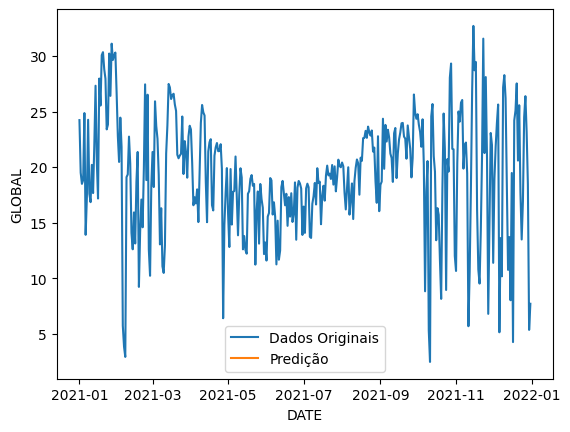

In [128]:
import pandas as pd
import numpy as np
import seaborn as sns

# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

print(predict_period_dates)

df_forecast = pd.DataFrame({'DATE': np.array(forecast_dates), 'GLOBAL': original})
df_forecast['DATE'] = pd.to_datetime(df_forecast['DATE'])

ori = data_copy[['DATE', 'GLOBAL']]
ori['DATE'] = pd.to_datetime(ori['DATE'])
ori = ori.loc[ori['DATE'] >= '2021-01-01']

pl.plot(ori['DATE'], ori['GLOBAL'], label='Dados Originais')
pl.plot(df_forecast['DATE'], df_forecast['GLOBAL'], label='Predição')
pl.xlabel('DATE')
pl.ylabel('GLOBAL')
pl.legend()
pl.show()


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(test_y, predictions)
r2 = r2_score(test_y, predictions)
mape = np.mean(np.abs((test_y - predictions) / test_y)) * 100
print('MSE: %.3f, R2: %.3f, MAPE: %.3f' % (mse, r2, mape))

In [ ]:
print(train_dates.shape)
print(original.shape)
print(original_test.shape)

# Plotar os resultados
pl.plot(original,color='C0',marker='o', label='Predição')
pl.plot(original_test,color='C1', marker='o', label='Dados Originais', alpha=0.6)
pl.legend()
pl.xlabel('Índice')
pl.ylabel('Valor')
pl.title('Dados Predição vs. Dados de Teste')
pl.show()